# Predictive Modelling of Proteomics using a Transformer Model

## Task Type and Model Decision
This task is a regression task, where one type of omics data is predicted using others. Both VAEs and Transformers are suitable choices: VAEs excel with noisy data and handle missing values well, while Transformers are powerful for capturing complex interactions between features through their self-attention mechanism.

I selected a Transformer model because the multi-head attention can learn different types of relationships between omics data features and capturing various correlations that might exist. The self-attention mechanism allows the model to identify important feature interactions, which I think are important in multi-omics data integration. While VAEs would also be suitable, particularly for handling noise and missing values, the potential complex interactions between omics data features made Transformers my preferred choice.

## Data
The aim is to use multiple input omics datasets to predict proteomics data. Input omics data was selected by iteratively testing combinations to determine which best predicted proteomics. This indicated that transcriptomics data only as the optimal input combination for proteomics prediction.

## Plan
The approach follows a systematic comparison between a baseline MLP model and the Transformer architecture:

#### In EMBL_transformer_explore.ipynb
1. [Inspect data](#inspect-data);
2. [Create a simple MLP model](#baseline-mlp) as a baseline;
3. [Develop Transformer models](#transformer-models) with different fusion strategies and activation functions;
4. [Perform hyperparameter tuning](#hyperparameter-tuning);
5. [Conduct progressive input omics selection](#omics-selection);
6. [Create comprehensive loop](#evaluation-loop) to iterate through steps 3-5, obtaining metrics to determine the best Transformer model for comparison with the baseline MLP;

#### In EMBL_transformer_best_model.ipynb
7. [Select best-performing model](#best-performing);
8. [Analyse best-predicted proteomic features](#feature-analysis);


## Results
- The [baseline MLP model](#results-MLP) performed quite well already, with an R^2 ~0.83, an RMSE ~0.69, and prediction errors that are roughly Normally distributed.
- The best [Transformer model](#results-transformer) demonstrated that using transcriptomics data only as input omics data performed best, with R^2 ~0.83. However, rerunning the algorithm shows some variability in the best performing hyperparameters, such as fusion method selected. In addition, the Transformer model does not significantly outperform the baseline MLP model. Moving forward, cross-validation and improved data handling (e.g. outlier handling) would be worth exploring. 
- The results of the [feature analysis](#results-feature-analysis) showed significant correlation values >0.5 between the predicted and actual values. However, the R^2 values are low, indicating that while the general trends in protein expression are captured, the model does not accurately predict the exact values. 

## Future Work
Given more time, I would implement:

1. Cross-validation for more robust model evaluation;
2. Enhanced data handling, particularly for outliers. Despite the task stating the data was "processed and cleaned, so you can use them directly" I encountered outliers that might affect results. Going forward, I would address these outliers prior to modelling;
3. Development of ensemble methods to potentially improve prediction accuracy.



In [1]:
#TODO: add more modalities, and make it optional
#TODO: refactor into proper code base

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import math
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

from scipy.stats import zscore, pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna

/home/jantine/miniconda3/envs/transformer_proteomics/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load data and create data paths
model_path = Path("models/")
result_path = Path("results/")
data_path_lung = Path("data/")  # lung carcinome data

# Check if the directories exist, and create them if they don't
if not model_path.exists():
    model_path.mkdir(parents=True)
if not result_path.exists():
    result_path.mkdir(parents=True)
if not data_path_lung.exists():
    data_path_lung.mkdir(parents=True)

# Load data
prefix = "20231023_092657_"
datasets = {
    "methylation": pd.read_csv(data_path_lung / f"{prefix}imputed_methylation.csv"),
    "metabolomics": pd.read_csv(data_path_lung / f"{prefix}imputed_metabolomics.csv"),
    "proteomics": pd.read_csv(data_path_lung / f"{prefix}imputed_proteomics.csv"),
    "transcriptomics": pd.read_csv(data_path_lung / f"{prefix}imputed_transcriptomics.csv"),
    "cnv": pd.read_csv(data_path_lung / f"{prefix}imputed_copynumber.csv"),
}

# Inspect Data <a id="inspect-data"></a>

This part includes:
- Loading the data;
- Quick scan through data to get an intuition;
- Visualise the distribution and characteristics of the data:
    - Distribution plots: skewness, normality, etc.
    - Boxplots: median, quartiles, and outliers for first 20 features.
    - Heatmap: patterns, clusters, and correlations between samples and features.
    - Z-score: outlier detection.
    - PCA: the PC that explains most of the variance.

In [5]:
# Get the patient ID column name
patient_id_col = list(datasets.values())[0].columns[0]

# Reference/Target dataset, i.e. proteomics
reference = "proteomics"
reference_df = datasets[reference]
reference_ids = list(reference_df[patient_id_col])

# Check all datasets
for name, df in datasets.items():
    current_ids = list(df[patient_id_col])

    # Check if patient IDs are the same
    same_ids = set(reference_ids) == set(current_ids)
    print(f"{name}: Same IDs as {reference}: {same_ids}")

    # Check if patient IDs are in the same order
    same_order = reference_ids == current_ids
    print(f"{name}: Same order as {reference}: {same_order}")
    print(f"-------------------------------------------------\n")

methylation: Same IDs as proteomics: True
methylation: Same order as proteomics: True
-------------------------------------------------

metabolomics: Same IDs as proteomics: True
metabolomics: Same order as proteomics: True
-------------------------------------------------

proteomics: Same IDs as proteomics: True
proteomics: Same order as proteomics: True
-------------------------------------------------

transcriptomics: Same IDs as proteomics: True
transcriptomics: Same order as proteomics: True
-------------------------------------------------

cnv: Same IDs as proteomics: True
cnv: Same order as proteomics: True
-------------------------------------------------



In [6]:
print(datasets["proteomics"].shape)
datasets["proteomics"].head()

(175, 4923)


Unnamed: 0     AAAS     AACS    AAGAB     AAK1    AAMDC     AAMP    AARS1  \
0  SIDM00046  3.35516  2.47970  2.64814  3.42747  2.29730  2.79989  5.03959   
1  SIDM00047  3.47470  1.78254  3.52149  2.92188  1.37197  2.97951  5.14901   
2  SIDM00048  3.56201  2.52743  3.26977  3.48947  2.15151  2.75366  5.11889   
3  SIDM00098  3.50973  2.33440  3.43963  3.32111  2.48636  3.17103  5.59721   
4  SIDM00099  3.54051  2.12653  2.91819  2.84000  2.05342  2.33734  4.71901   

     AARS2   AARSD1  ...   ZNF830   ZNHIT2    ZNRD2    ZNRF2     ZPR1  \
0  4.36283  2.83884  ...  0.94939  1.96832  4.87203  3.54926  2.74466   
1  3.88597  3.55916  ...  0.84154  1.78003  3.42515  2.79853  3.20215   
2  3.51744  3.29552  ...  1.34557  2.03291  4.14519  3.22756  3.29044   
3  3.94357  3.56998  ...  0.81172  1.79803  4.24853  3.12697  3.93978   
4  3.52292  2.09409  ...  0.35651  1.80656  3.25177  2.95097  2.55263   

    ZRANB2     ZW10   ZWILCH    ZWINT      ZYX  
0  3.96470  2.31081  1.44500  2.23063  4.87281  
1  4.02278  2.24471  1.87061  1.76904  4.96541  
2  3.98339  2.58220  2.09735  2.47003  4.91925  
3  4.55265  2.63257  1.90050  2.06059  5.91146  
4  3.52448  2.67204  1.77170  1.80426  5.53598  

[5 rows x 4923 columns]

In [7]:
print(datasets["transcriptomics"].shape)
datasets["transcriptomics"].head()

(175, 15279)


Unnamed: 0     A1BG     A1CF      A2M    A2ML1   A4GALT     AAAS     AACS  \
0  SIDM00046  2.04090 -5.30627 -1.25004 -1.32172  3.00924  5.27339  5.77792   
1  SIDM00047  1.01151 -3.45882 -0.39178 -3.98753  3.27545  5.79755  5.27295   
2  SIDM00048  0.43384 -4.20756 -0.63528 -1.37044  3.80196  5.79006  5.56590   
3  SIDM00098  1.69118 -4.16117 -0.22028 -4.65767  1.05576  5.66560  5.32404   
4  SIDM00099  1.70960 -4.00844  0.29479 -5.20683  2.16290  5.71212  5.52738   

     AADAC    AADAT  ...   ZWILCH    ZWINT     ZXDA     ZXDB     ZXDC  \
0 -1.93157  3.19395  ...  5.30791  6.61797  1.60898  3.89132  5.07034   
1  0.06323  3.18109  ...  5.77799  6.63569  2.52953  4.19684  4.53901   
2 -1.02246  2.43433  ...  5.56682  6.89185  2.52134  4.22761  4.88434   
3 -2.79352  1.49933  ...  5.78098  6.65350  2.05654  3.92582  4.89359   
4 -2.82416  1.96201  ...  5.81931  6.61506  2.39253  4.15398  4.57227   

    ZYG11A   ZYG11B      ZYX    ZZEF1     ZZZ3  
0  1.43384  4.89578  7.85737  6.32957  5.04573  
1 -0.83239  5.21132  7.02936  5.91940  5.83587  
2 -0.38911  5.10613  7.08207  6.02523  5.65201  
3 -1.52334  5.17720  7.11551  6.26238  5.83334  
4 -0.64660  5.43610  7.44160  6.32660  5.79604  

[5 rows x 15279 columns]

In [8]:
# Check stats data
datasets["proteomics"].describe()

AAAS        AACS       AAGAB        AAK1       AAMDC        AAMP  \
count  175.000000  175.000000  175.000000  175.000000  175.000000  175.000000   
mean     3.400439    2.377934    3.177170    2.724059    2.341307    2.882409   
std      0.470283    0.469785    0.417529    0.610718    0.729121    0.478877   
min      2.261750    1.417240    1.937800    0.348690    0.660860    1.004400   
25%      3.083055    2.025375    2.927475    2.354130    1.828220    2.615550   
50%      3.398410    2.336890    3.234950    2.787770    2.334570    2.884420   
75%      3.699850    2.747190    3.444095    3.162280    2.803920    3.199980   
max      4.646800    3.519890    4.381370    3.862940    4.080070    3.987030   

            AARS1       AARS2      AARSD1    AASDHPPT  ...      ZNF830  \
count  175.000000  175.000000  175.000000  175.000000  ...  175.000000   
mean     5.523704    3.596709    3.037507    3.706307  ...    0.650061   
std      0.851543    0.438702    0.812891    1.030560  ...    0.453352   
min      2.631040    2.186440   -0.332310    0.492090  ...   -0.676920   
25%      5.225035    3.301360    2.646140    2.995385  ...    0.382670   
50%      5.616790    3.626200    3.122430    3.714160  ...    0.688260   
75%      6.039545    3.868875    3.531480    4.502935  ...    0.914440   
max      7.790930    4.779400    5.018770    6.268380  ...    1.849370   

           ZNHIT2       ZNRD2       ZNRF2        ZPR1      ZRANB2        ZW10  \
count  175.000000  175.000000  175.000000  175.000000  175.000000  175.000000   
mean     2.014989    4.119399    3.217272    3.493170    4.231324    2.505658   
std      0.350896    0.721885    0.721797    0.930108    0.580388    0.350203   
min      0.857180    1.500380    0.663890   -0.631570    1.852800    0.946650   
25%      1.822205    3.683940    2.722190    2.874340    3.895065    2.306375   
50%      2.020420    4.148540    3.227560    3.600800    4.346080    2.550300   
75%      2.244375    4.567050    3.721380    4.143840    4.680215    2.752860   
max      3.149980    6.028390    4.803140    5.428910    5.374170    3.259980   

           ZWILCH       ZWINT         ZYX  
count  175.000000  175.000000  175.000000  
mean     1.867428    2.051336    3.767167  
std      0.398492    0.359551    1.612974  
min      0.617650    0.876150   -0.208100  
25%      1.650770    1.858410    2.222515  
50%      1.939080    2.060590    3.947790  
75%      2.114425    2.302500    5.132505  
max      2.710440    2.859270    6.776770  

[8 rows x 4922 columns]

In [9]:
# Check missing values
for dataset_name, dataset in datasets.items():
    print(f"Checking missing data for {dataset_name} dataset...")
    
    if dataset.isnull().values.any():
        print(f"Missing data found in {dataset_name} dataset.")
        
        # Count missing values for each feature
        missing_counts = dataset.isnull().sum()
        ranked_features = missing_counts[missing_counts > 0].sort_values(ascending=False)
        print(f"Features with missing values (ranked):\n{ranked_features}\n")
    
    else:
        print(f"No missing data in {dataset_name} dataset.\n")

Checking missing data for methylation dataset...
No missing data in methylation dataset.

Checking missing data for metabolomics dataset...
No missing data in metabolomics dataset.

Checking missing data for proteomics dataset...
No missing data in proteomics dataset.

Checking missing data for transcriptomics dataset...
No missing data in transcriptomics dataset.

Checking missing data for cnv dataset...
No missing data in cnv dataset.



Analysing methylation dataset...


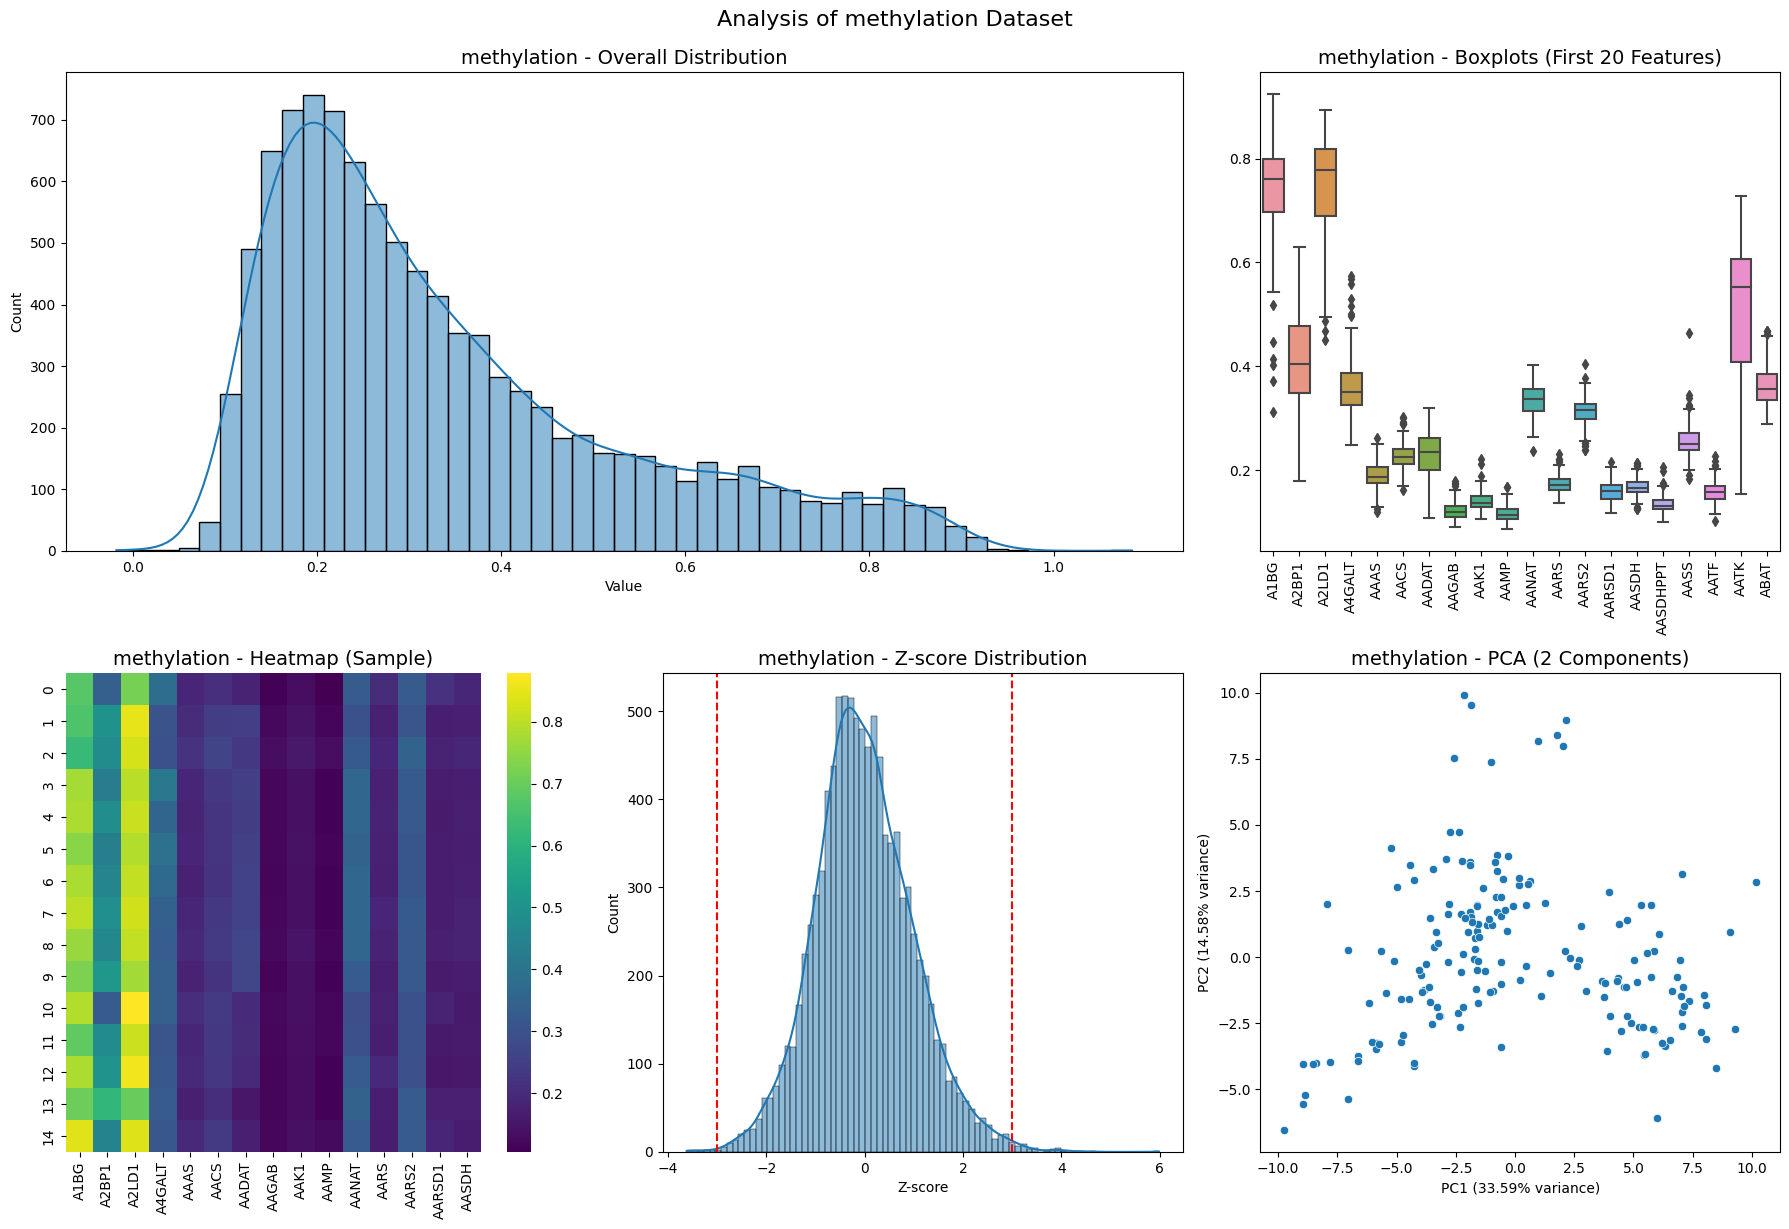

Analysing metabolomics dataset...


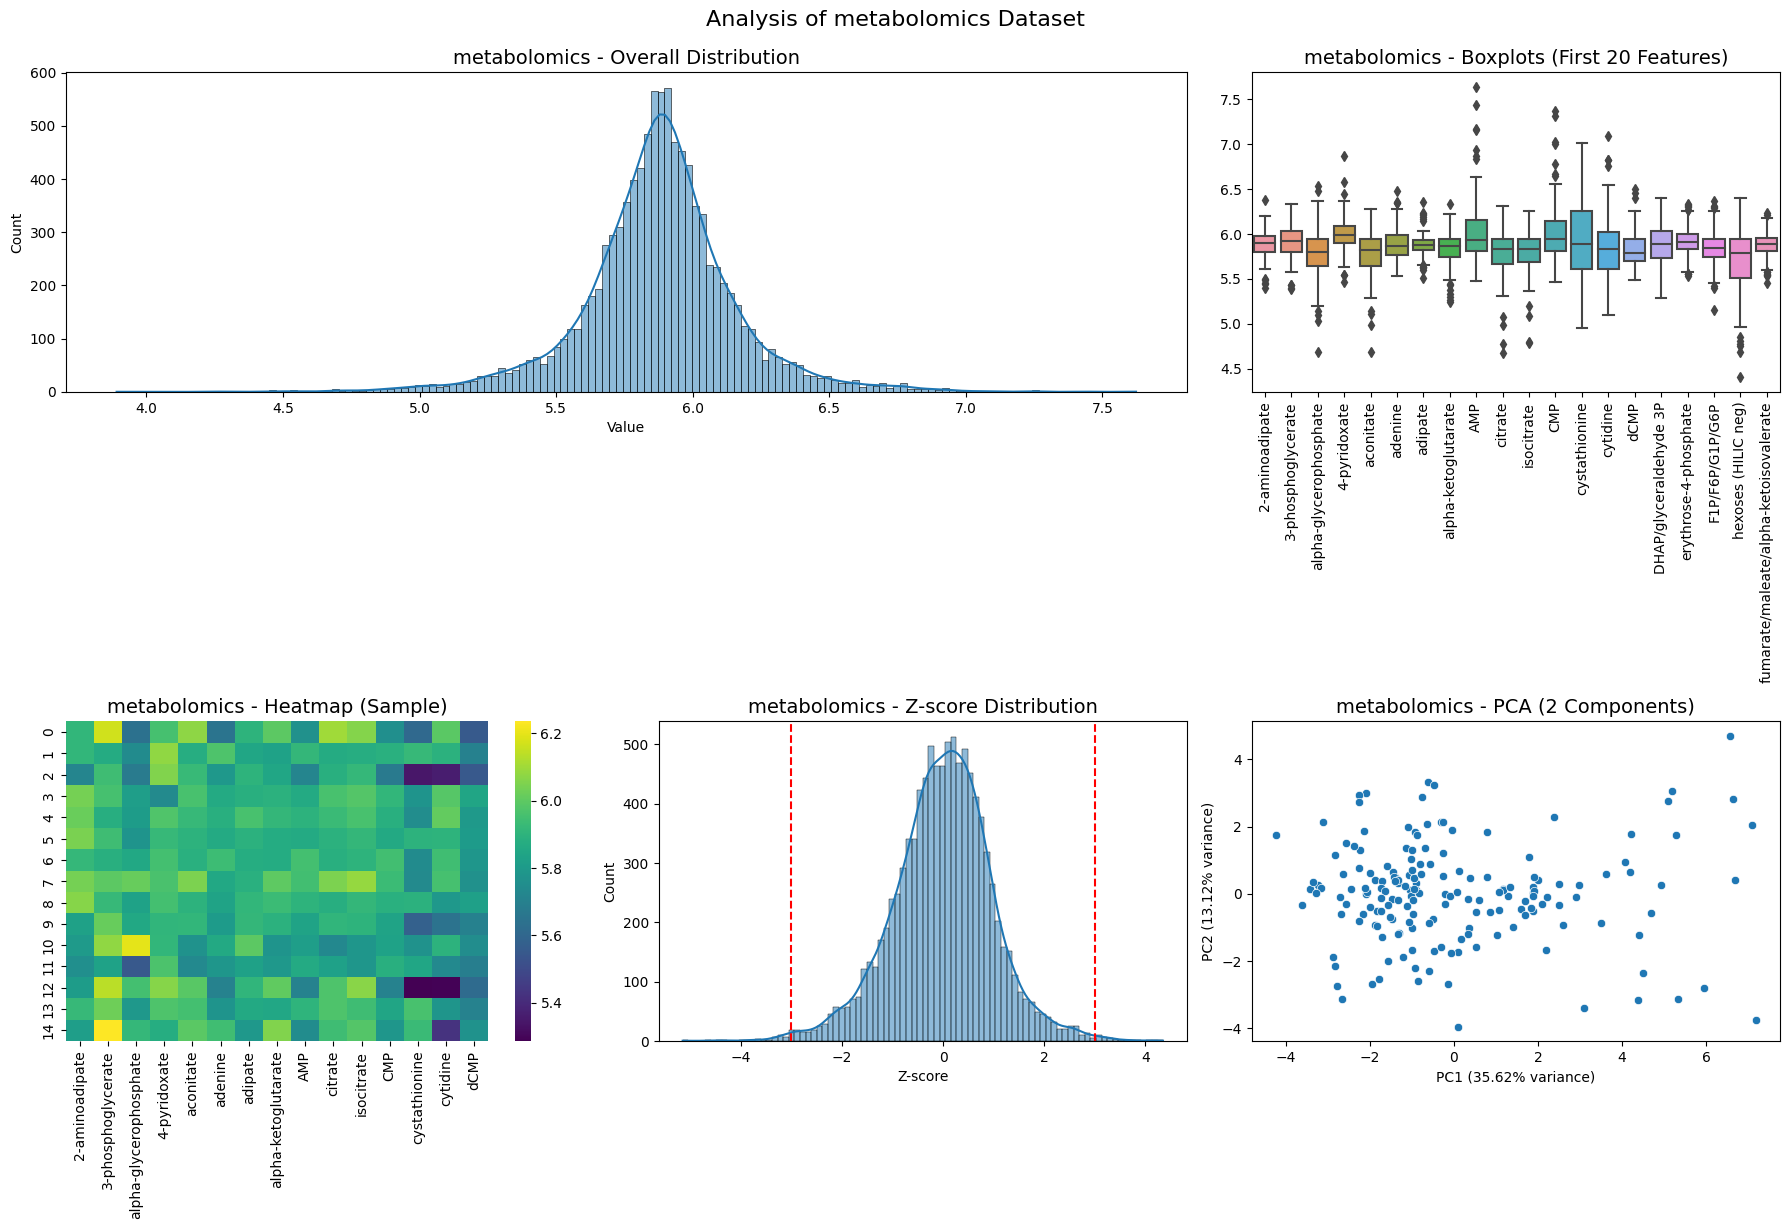

Analysing proteomics dataset...


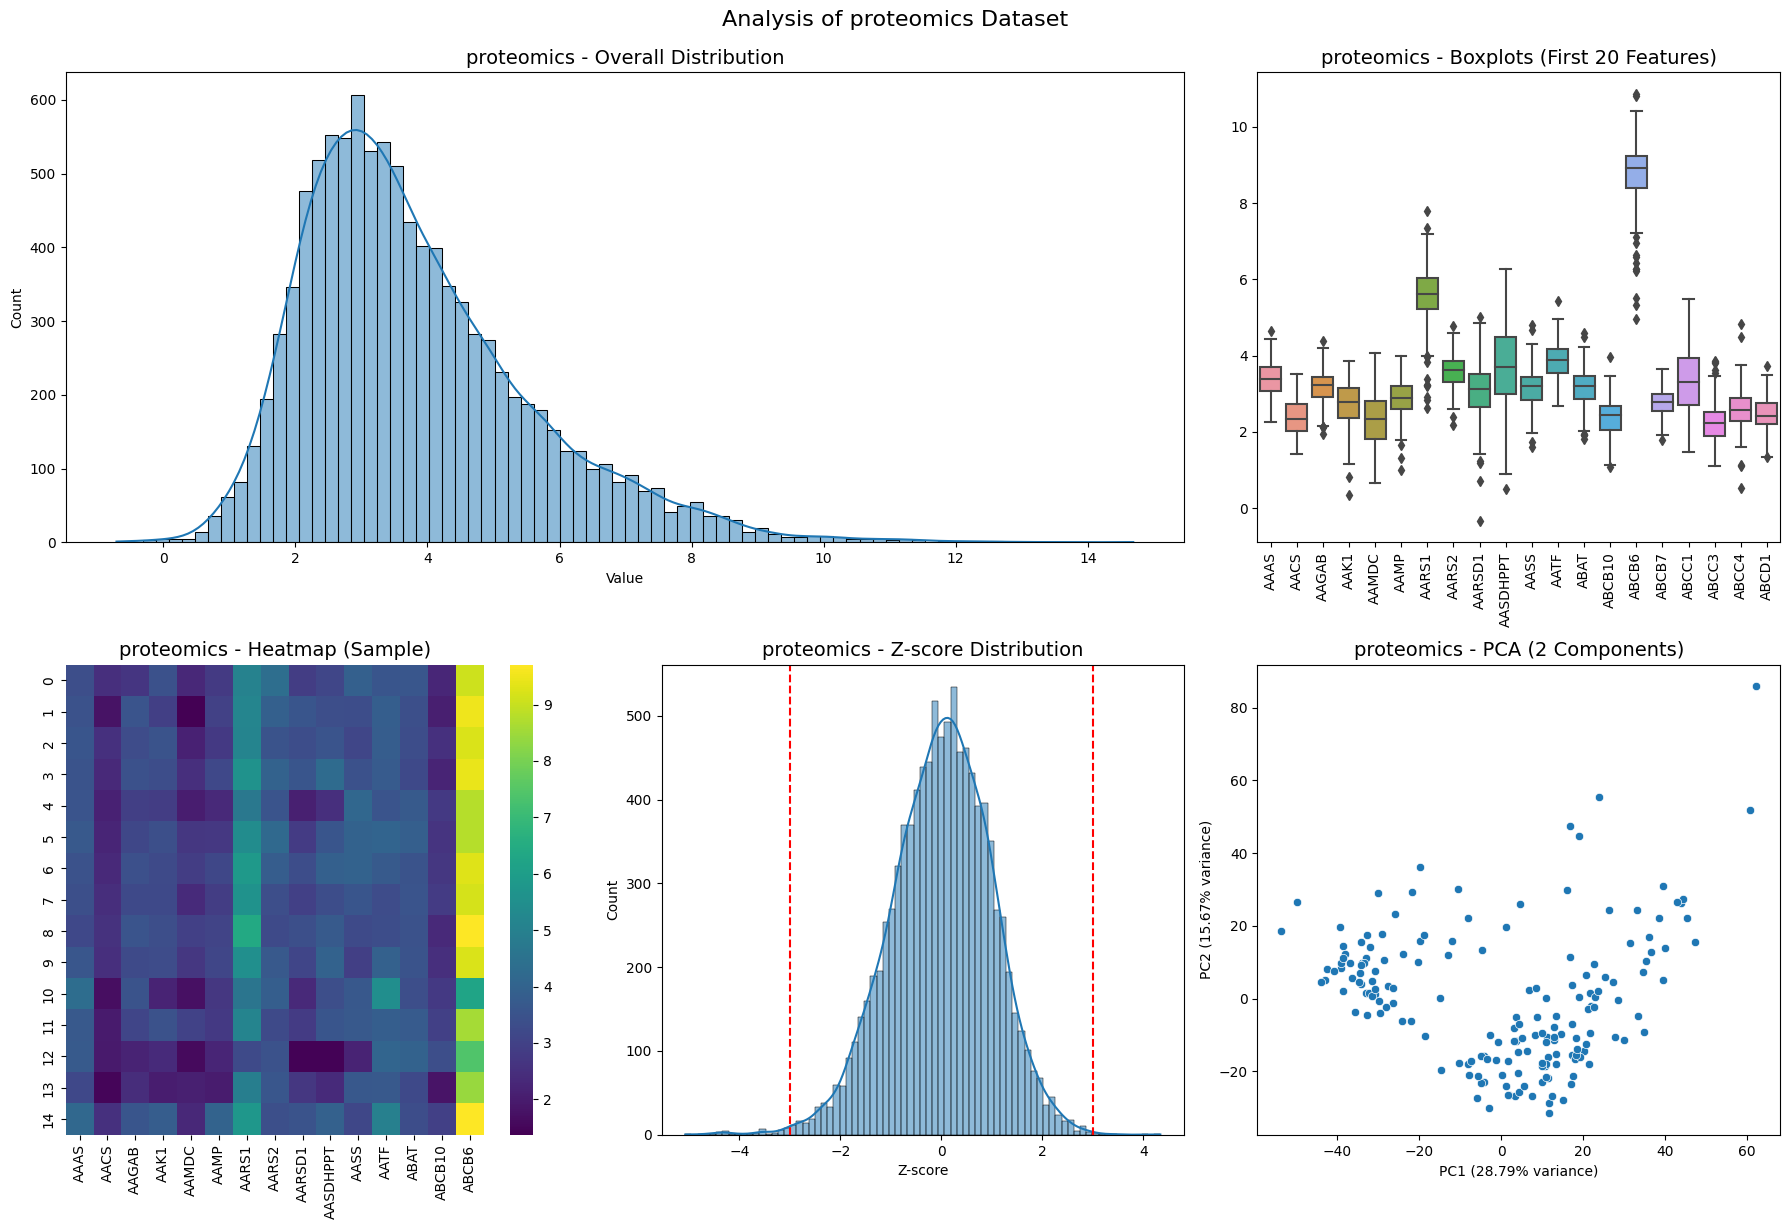

Analysing transcriptomics dataset...


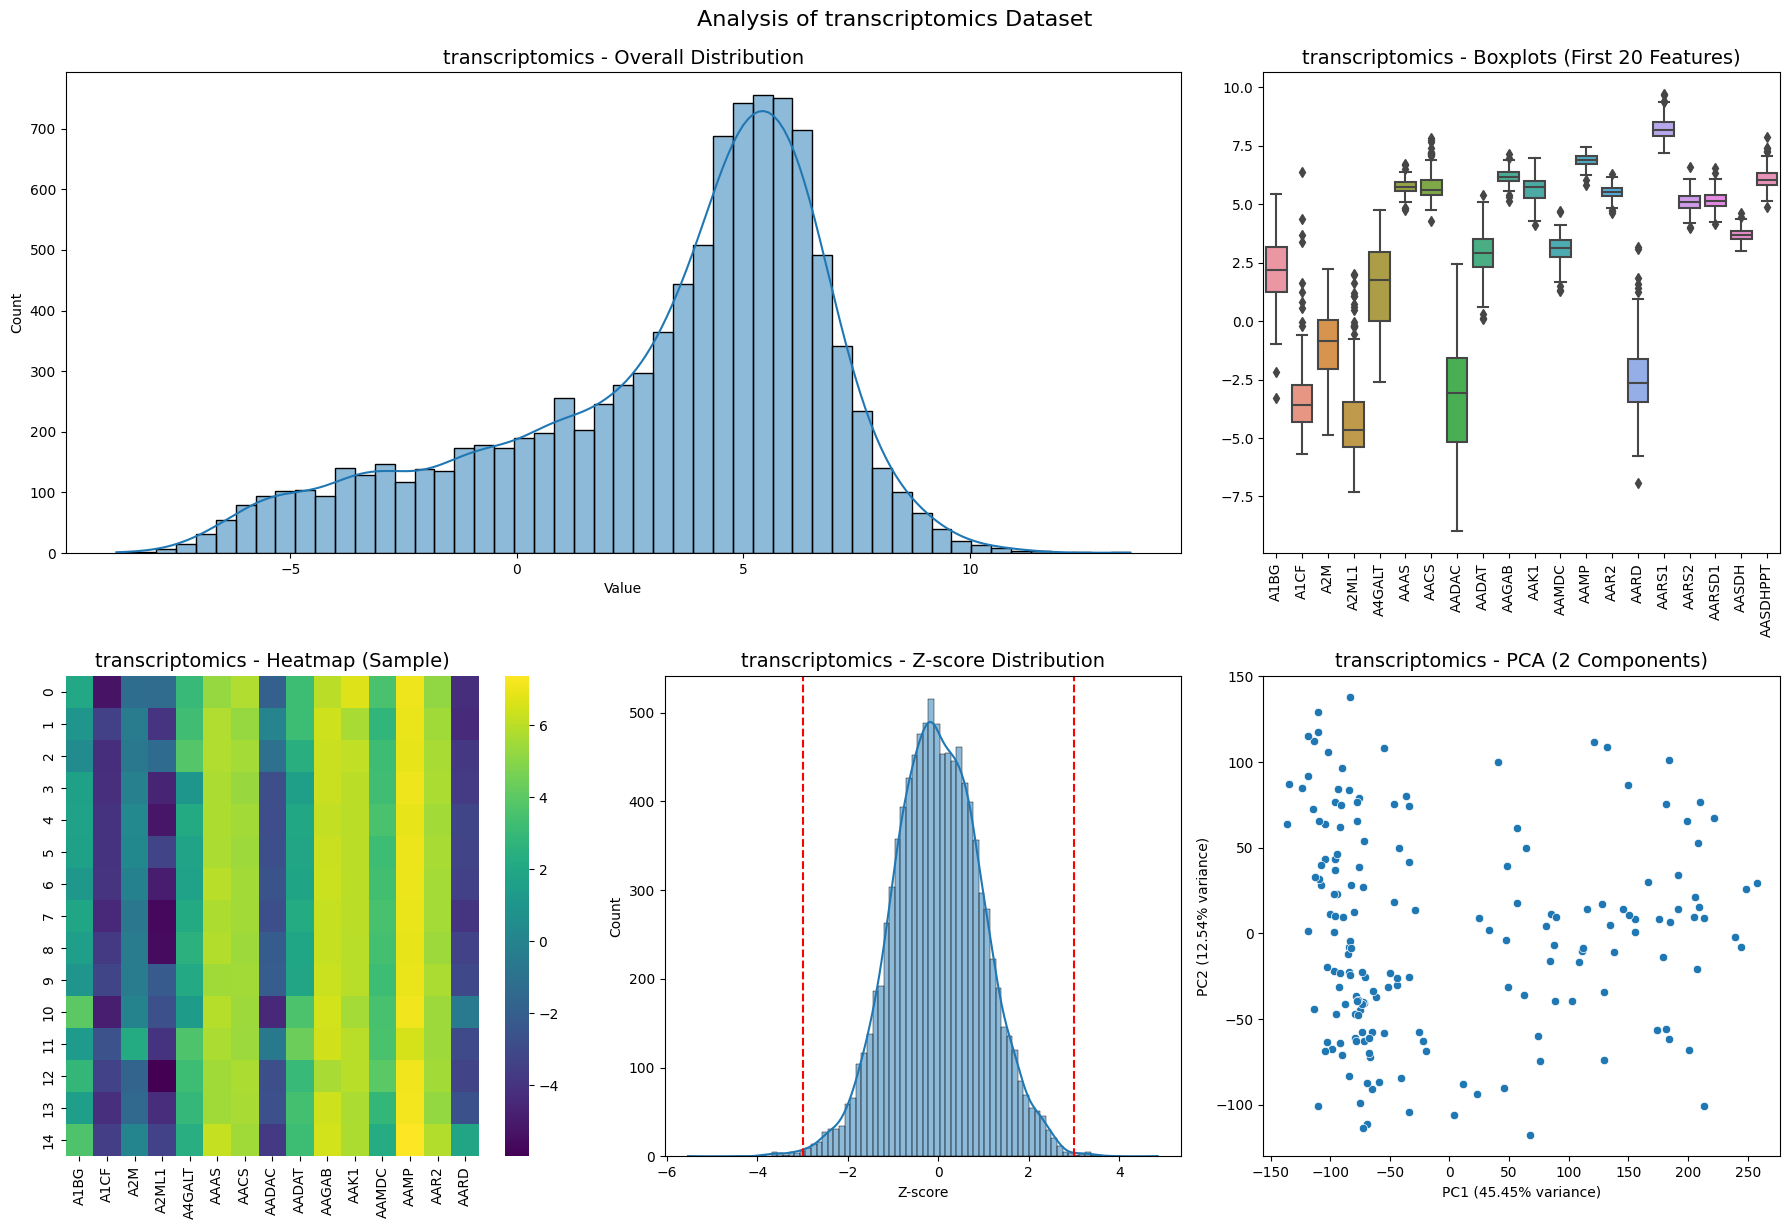

Analysing cnv dataset...


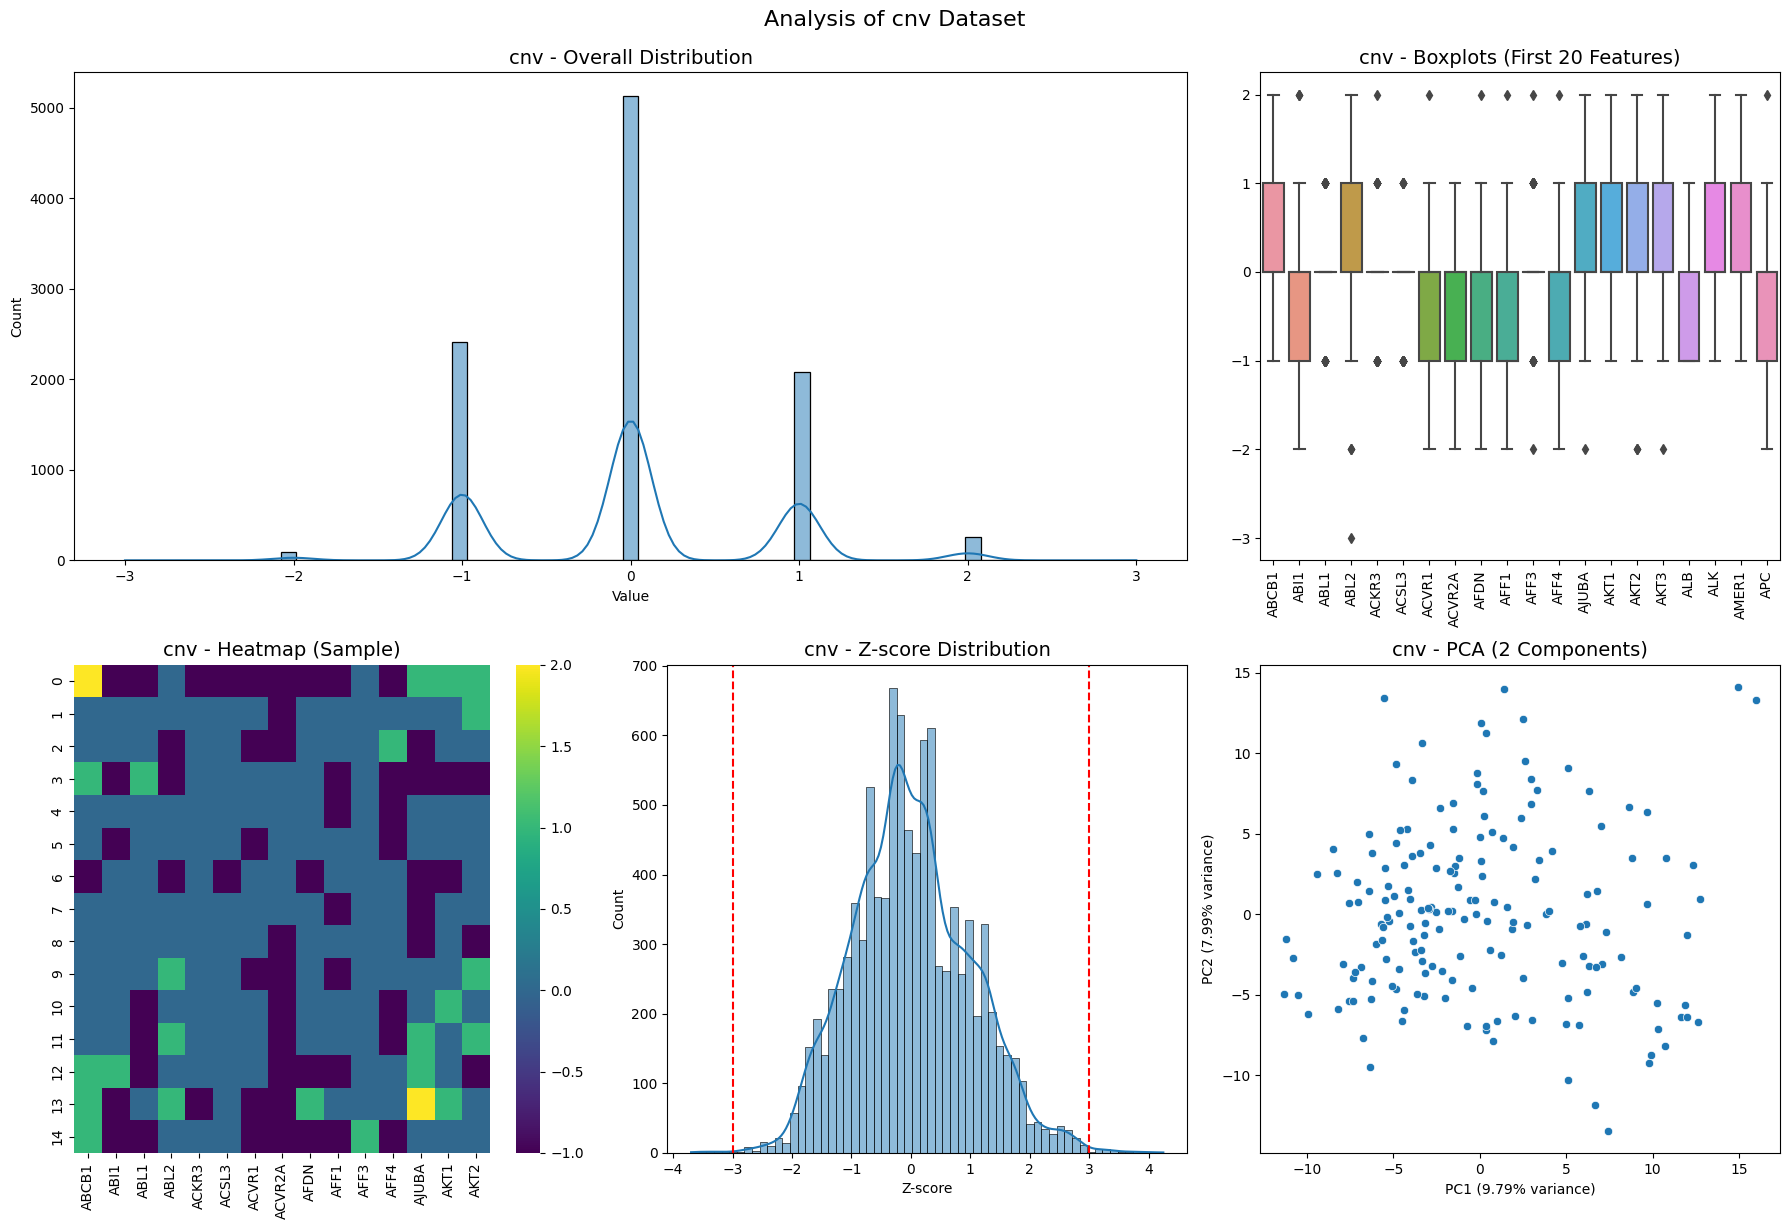

In [10]:
# Visualise data
def plot_distribution_and_outliers(dataset_name, dataset):
    """Visualise distribution and outliers for the datasets"""
    data = dataset.iloc[:, 1:]  # skip first column, as this is the sample ID
    
    # Plot
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
    
    # 1. Distribution plot
    ax1 = plt.subplot(gs[0, 0:2])
    sampled_values = data.values.flatten()
    np.random.shuffle(sampled_values)
    sampled_values = sampled_values[:10000]  # Sample 1000 random values
    sns.histplot(sampled_values, kde=True, ax=ax1)
    ax1.set_title(f"{dataset_name} - Overall Distribution", fontsize=14)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Count")
    
    # 2. Boxplot for first 20 features
    ax2 = plt.subplot(gs[0, 2])
    sns.boxplot(data=data.iloc[:, :20], ax=ax2)
    ax2.set_title(f"{dataset_name} - Boxplots (First 20 Features)", fontsize=14)
    ax2.set_xticklabels(data.columns[:20], rotation=90)
    
    # 3. Heatmap of the data: samples vs features
    ax3 = plt.subplot(gs[1, 0])
    sample_data = data.iloc[:15, :15]
    sns.heatmap(sample_data, cmap="viridis", ax=ax3)
    ax3.set_title(f"{dataset_name} - Heatmap (Sample)", fontsize=14)
    
    # 4. Z-score distribution to identify outliers
    ax4 = plt.subplot(gs[1, 1])
    z_data = data.apply(zscore)
    z_flattened = z_data.values.flatten()
    np.random.shuffle(z_flattened)
    z_flattened = z_flattened[:10000]  # Sample 1000 for better visualisation
    sns.histplot(z_flattened, kde=True, ax=ax4)
    ax4.axvline(x=3, color="r", linestyle="--")
    ax4.axvline(x=-3, color="r", linestyle="--")
    ax4.set_title(f"{dataset_name} - Z-score Distribution", fontsize=14)
    ax4.set_xlabel("Z-score")
    ax4.set_ylabel("Count")
    
    # 5. PCA
    ax5 = plt.subplot(gs[1, 2])
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], ax=ax5)
    ax5.set_title(f"{dataset_name} - PCA (2 Components)", fontsize=14)
    ax5.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    ax5.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    
    plt.tight_layout()
    plt.suptitle(f"Analysis of {dataset_name} Dataset", fontsize=16, y=1.02)
    return fig, z_data


# Plot for all datasets
for dataset_name, dataset in datasets.items():
    print(f"Analysing {dataset_name} dataset...")
    fig1, z_data = plot_distribution_and_outliers(dataset_name, dataset)
    plt.figure(fig1.number)
    plt.show()

In [11]:
# Check outliers
z_scores = datasets["proteomics"].iloc[:, 1:].apply(zscore)

# Outliers (Z-score > 3 or < -3)
outliers = (z_scores.abs() > 3).sum(axis=0)

# Count the number of features for each number of outliers
outlier_counts = outliers.value_counts().sort_index()
for num_outliers, num_features in outlier_counts.items():
    print(f"{num_outliers} outliers: {num_features} features")


0 outliers: 1670 features
1 outliers: 1816 features
2 outliers: 1100 features
3 outliers: 276 features
4 outliers: 52 features
5 outliers: 8 features


### Cleaning data
The data is supposed to be clean and processed, so no StandardScaler or other QCs necessary. However, the initial inspection shows that we do deal with skewed data and outliers. I will go ahead with the data as is, as this is mentioned in the task description. There seems to be no missing values of NaNs, so that is not a concern. 

# Prepare multi-omic data for model ingestion


In [12]:
class MultiOmicsDataset(torch.utils.data.Dataset):
    def __init__(self, datasets_dict, input_omics, target_omics, indices):
        """
        datasets_dict: full omics dataset dictionary (e.g., methylation, transcriptomics, etc.)
        input_omics: list of omics types to use as input
        target_omics: single omics type to predict
        indices: sample indices to include (for train/test split)
        """
        self.inputs = {
            omics: torch.tensor(datasets_dict[omics].iloc[indices, 1:].values, dtype=torch.float32)
            for omics in input_omics
        }
        self.targets = torch.tensor(datasets_dict[target_omics].iloc[indices, 1:].values, dtype=torch.float32)
        self.omics_keys = input_omics
        self.length = len(indices)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = {omics: tensor[idx] for omics, tensor in self.inputs.items()}
        y = self.targets[idx]
        return x, y


In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def get_multiomics_dataloaders(datasets, input_omics, target_omics, batch_size=32, test_size=0.2):
    # Split on common indices
    n_samples = datasets[target_omics].shape[0]
    indices = np.arange(n_samples)
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42)

    train_dataset = MultiOmicsDataset(datasets, input_omics, target_omics, train_idx)
    test_dataset = MultiOmicsDataset(datasets, input_omics, target_omics, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# MLP Base Model <a id="baseline-mlp"></a> 
The idea is to start with a simple MLP base model with a few hidden layers to serve as a benchmark for the Transformer. This base model will also only use one type of input omics data, i.e. transcriptomics, to predict the proteomics data.  

In [15]:
print("Available datasets:", datasets.keys())

Available datasets: dict_keys(['methylation', 'metabolomics', 'proteomics', 'transcriptomics', 'cnv'])


In [16]:
# Choose input data set and target
input_datasets = ["transcriptomics", "methylation", "metabolomics", "cnv"]  # as many as you want
target_dataset = "proteomics"

train_loader, test_loader = get_multiomics_dataloaders(
    datasets=datasets,
    input_omics=input_datasets,
    target_omics=target_dataset,
    batch_size=32,
    test_size=0.2
)

# Define input dims per omics
input_dims_dict = {
    omic: datasets[omic].shape[1] - 1  # exclude patient ID column
    for omic in input_datasets
}

# Output dimension (target omic)
output_dim = datasets[target_dataset].shape[1] - 1

# # Split data into features (X) and target (y)
# X = datasets[input_datasets[0]].iloc[:, 1:].values  # Exclude patient ID column
# y = datasets[target_dataset].iloc[:, 1:].values    

# # Split into training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Create TensorDataset and DataLoaders
# dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
# dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
# train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
# test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [17]:
class MultiOmicsMLP(nn.Module):
    def __init__(self, input_dims_dict, output_dim, hidden_dims=[256, 128, 64]):
        super(MultiOmicsMLP, self).__init__()
        
        self.input_keys = sorted(input_dims_dict.keys())
        total_input_dim = sum(input_dims_dict[k] for k in self.input_keys)

        layers = [nn.Linear(total_input_dim, hidden_dims[0]), nn.ReLU()]
        for i in range(len(hidden_dims) - 1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i+1]), nn.ReLU()]
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x_dict):
        x = torch.cat([x_dict[k] for k in self.input_keys], dim=-1)
        return self.model(x)

In [18]:
# Initialize model with multi-omics input dims
mlp_model = MultiOmicsMLP(
    input_dims_dict=input_dims_dict,
    output_dim=output_dim,
    hidden_dims=[256, 128, 64]
).to(device)

# Loss function and optimiser
mlp_criterion = nn.MSELoss()
learning_rate = 0.001
weight_decay = 0
mlp_optimiser = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping setup
patience = 15
best_loss = float("inf")
counter = 0
best_model_state = None

# Train loop
train_losses = []
test_losses = []
epochs = 100

from tqdm import tqdm  # For progress bar

for epoch in range(epochs):
    mlp_model.train()
    running_loss = 0.0

    for x_dict, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Move all modalities in the dict to device
        x_dict = {k: v.to(device) for k, v in x_dict.items()}
        targets = targets.to(device)

        mlp_optimiser.zero_grad()
        outputs = mlp_model(x_dict)
        loss = mlp_criterion(outputs, targets)
        loss.backward()
        mlp_optimiser.step()

        running_loss += loss.item() * targets.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation
    mlp_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_dict, targets in test_loader:
            x_dict = {k: v.to(device) for k, v in x_dict.items()}
            targets = targets.to(device)

            outputs = mlp_model(x_dict)
            loss = mlp_criterion(outputs, targets)

            test_loss += loss.item() * targets.size(0)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Early stopping
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        counter = 0
        best_model_state = mlp_model.state_dict().copy()
    else:
        counter += 1

    # Progress logging
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Early Stopping: {counter}/{patience}")

    if counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        mlp_model.load_state_dict(best_model_state)
        break

# Load best model
mlp_model.load_state_dict(best_model_state)

# Save model
torch.save(mlp_model.state_dict(), model_path / "best_multiomics_mlp_model.pt")


Epoch 1/100 | Train Loss: 19.9509 | Test Loss: 17.2232 | Early Stopping: 0/15


Epoch 11/100 | Train Loss: 1.3363 | Test Loss: 1.2212 | Early Stopping: 0/15


Epoch 21/100 | Train Loss: 0.4527 | Test Loss: 0.4931 | Early Stopping: 0/15


Epoch 31/100 | Train Loss: 0.4372 | Test Loss: 0.4789 | Early Stopping: 0/15


Epoch 41/100 | Train Loss: 0.4474 | Test Loss: 0.4763 | Early Stopping: 0/15


Epoch 51/100 | Train Loss: 0.4283 | Test Loss: 0.4755 | Early Stopping: 0/15


Epoch 61/100 | Train Loss: 0.4245 | Test Loss: 0.4736 | Early Stopping: 0/15


Epoch 71/100 | Train Loss: 0.4310 | Test Loss: 0.4795 | Early Stopping: 10/15



Early stopping at epoch 76


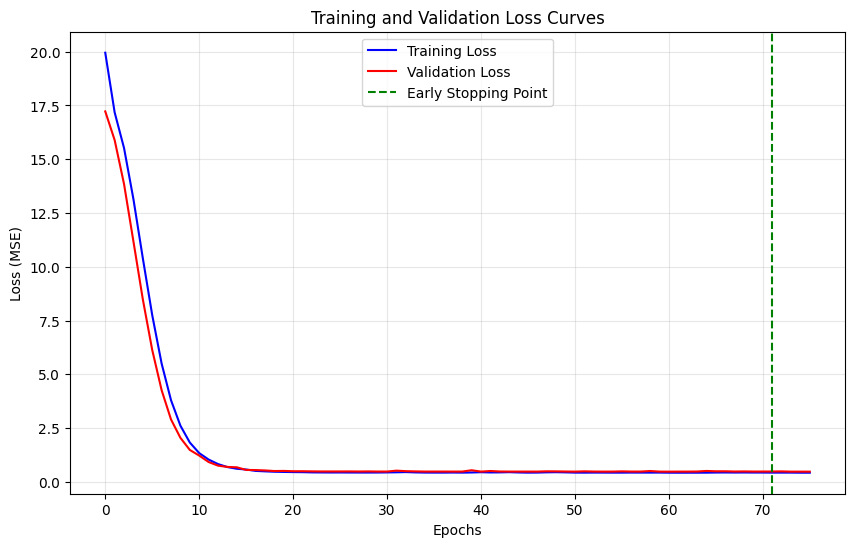

In [19]:
# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
ax.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax.plot(range(len(test_losses)), test_losses, label="Validation Loss", color="red")
ax.axvline(x=71, color="green", linestyle="--", label="Early Stopping Point")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Training and Validation Loss Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [20]:
# Evaluate model performance
mlp_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        targets = targets.to(device)

        outputs = mlp_model(inputs)

        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Calculate overall metrics
r2 = r2_score(all_targets.flatten(), all_predictions.flatten())
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
mae = mean_absolute_error(all_targets, all_predictions)
evs = explained_variance_score(all_targets.flatten(), all_predictions.flatten())

print(f"Overall MLP Model Performance:")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")


Overall MLP Model Performance:
R-squared (R²): 0.8407
Root Mean Squared Error (RMSE): 0.6885
Mean Absolute Error (MAE): 0.5038
Explained Variance Score: 0.8407


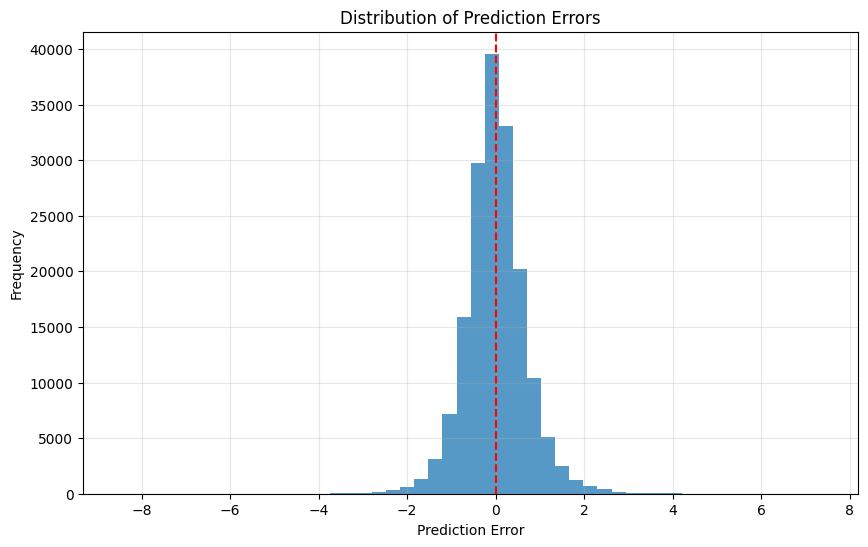

In [21]:
# Plot error distribution
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
errors = (all_predictions - all_targets).flatten()
ax.hist(errors, bins=50, alpha=0.75)
ax.axvline(x=0, color="red", linestyle="--")
ax.set_xlabel("Prediction Error")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Prediction Errors")
ax.grid(True, alpha=0.3)
plt.show()

# Baseline MLP Results <a id="results-MLP"></a>

The MLP is performing quite well already, with R^2 of ~0.83 and the error distribution normally distributed. The errors look Normally distributed, so the MLP is already performing well without systematically overestimating/underestimating the target values. 

# Transformer <a id="transformer-models"></a> 

This part is the development of the Transformer model. The Transformer model is designed so that it can be used to iteratively scan through different combinations of input omics data, fusion strategies, activation function (only ReLU and GeLU, as I'm working with PyTorch), and for hyperparameter optimisation.

In [22]:
class RefinedOmicsTransformer(nn.Module):
    def __init__(self, input_dims, output_dim, hidden_dim=256, num_heads=8,
                 num_layers=6, dropout=0.1, use_batch_norm=True, use_input_norm=True,
                 activation_fn="gelu", use_modality_embedding=True, pooling_type="attention"):
        super(RefinedOmicsTransformer, self).__init__()

        self.modalities = list(input_dims.keys())
        self.hidden_dim = hidden_dim
        self.use_batch_norm = use_batch_norm
        self.use_input_norm = use_input_norm
        self.use_modality_embedding = use_modality_embedding
        self.pooling_type = pooling_type
        self.activation_fn = self._get_activation(activation_fn)

        # Optional input normalization (per modality)
        self.input_norms = nn.ModuleDict()
        for omics, input_dim in input_dims.items():
            self.input_norms[omics] = nn.LayerNorm(input_dim) if use_input_norm else nn.Identity()

        # Embedding layers with optional normalization
        self.embeddings = nn.ModuleDict()
        for omics, input_dim in input_dims.items():
            layers = [nn.Linear(input_dim, hidden_dim)]
            layers.append(self._norm_layer(hidden_dim))
            layers.extend([
                self.activation_fn,
                nn.Dropout(dropout * 0.5)
            ])
            self.embeddings[omics] = nn.Sequential(*layers)

        self.modality_embeddings = nn.Parameter(
            torch.randn(len(input_dims), hidden_dim) * 0.02
        ) if use_modality_embedding else None

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation=activation_fn,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.attention_pooling = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.pooling_query = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)

        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            self._norm_layer(hidden_dim * 2),
            self.activation_fn,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            self._norm_layer(hidden_dim),
            self.activation_fn,
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim, output_dim)
        )

        self.feature_importance = nn.Parameter(torch.ones(len(input_dims)))

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def _norm_layer(self, dim):
        if self.use_batch_norm:
            return nn.BatchNorm1d(dim)
        elif self.use_input_norm:
            return nn.LayerNorm(dim)
        else:
            return nn.Identity()

    def _get_activation(self, name):
        if isinstance(name, str):
            name = name.lower()
            if name == "gelu":
                return nn.GELU()
            elif name == "relu":
                return nn.ReLU()
            elif name == "identity":
                return nn.Identity()
            else:
                raise ValueError(f"Unknown activation: {name}")
        return name

    def forward(self, x_dict):
        batch_size = next(iter(x_dict.values())).size(0)

        modality_embeddings = []
        feature_weights = torch.softmax(self.feature_importance, dim=0)

        for i, omics in enumerate(self.modalities):
            x = self.input_norms[omics](x_dict[omics])
            x_embedded = self.embeddings[omics](x)

            if self.use_modality_embedding:
                modality_embed = self.modality_embeddings[i].unsqueeze(0).expand(batch_size, -1)
                x_embedded = x_embedded + modality_embed

            x_embedded = x_embedded * feature_weights[i]
            modality_embeddings.append(x_embedded.unsqueeze(1))

        x = torch.cat(modality_embeddings, dim=1)
        x_transformed = self.transformer(x)

        if self.pooling_type == "attention":
            query = self.pooling_query.expand(batch_size, -1, -1)
            pooled, attention_weights = self.attention_pooling(query, x_transformed, x_transformed)
            pooled = pooled.squeeze(1)
        elif self.pooling_type == "mean":
            pooled = x_transformed.mean(dim=1)
            attention_weights = torch.ones(batch_size, len(self.modalities)) / len(self.modalities)
        elif self.pooling_type == "max":
            pooled, _ = x_transformed.max(dim=1)
            attention_weights = torch.ones(batch_size, len(self.modalities)) / len(self.modalities)
        elif self.pooling_type == "concat":
            pooled = x_transformed.view(batch_size, -1)
            attention_weights = torch.ones(batch_size, len(self.modalities)) / len(self.modalities)
        else:
            raise ValueError(f"Unknown pooling_type: {self.pooling_type}")

        output = self.prediction_head(pooled)

        return output, attention_weights.squeeze(1)


# Training

In [23]:
# Initialize model with multi-omics input dims
transformer_model = RefinedOmicsTransformer(
    input_dims=input_dims_dict,
    output_dim=output_dim,
    hidden_dim=256,  # 256, 512, -> Larger embedding space
    num_heads=4,     # 4, 8, 16 -> More attention heads
    num_layers=4,   # 4, 8 -> Deeper transformer
    dropout=0.01,     # Regularization
    use_batch_norm=False, 
    use_input_norm=False,
    activation_fn="gelu",  # "gelu", "relu", "identity"
    use_modality_embedding=False,
    pooling_type="attention"  # "attention", "mean", "max", "concat"
).to(device)

# Loss function and optimiser
transformer_criterion = nn.MSELoss()
learning_rate = 0.001
weight_decay = 0
transformer_optimiser = optim.AdamW(transformer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping setup
patience = 20
best_loss = float("inf")
counter = 0
best_model_state = None

# Train loop
train_losses = []
test_losses = []
epochs = 100

from tqdm import tqdm 

for epoch in range(epochs):
    transformer_model.train()
    running_loss = 0.0

    for x_dict, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Move all modalities in the dict to device
        x_dict = {k: v.to(device) for k, v in x_dict.items()}
        targets = targets.to(device)

        transformer_optimiser.zero_grad()
        outputs, _= transformer_model(x_dict)
        loss = transformer_criterion(outputs, targets)
        loss.backward()
        transformer_optimiser.step()

        running_loss += loss.item() * targets.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation
    transformer_model.eval()
    test_loss = 0.0
    all_weights = []
    with torch.no_grad():
        for x_dict, targets in test_loader:
            x_dict = {k: v.to(device) for k, v in x_dict.items()}
            targets = targets.to(device)

            outputs, attn_weights = transformer_model(x_dict)
            all_weights.append(attn_weights.cpu())
            
            loss = transformer_criterion(outputs, targets)

            test_loss += loss.item() * targets.size(0)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Early stopping
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        counter = 0
        best_model_state = transformer_model.state_dict().copy()
    else:
        counter += 1

    # Progress logging
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Early Stopping: {counter}/{patience}")

    if counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        transformer_model.load_state_dict(best_model_state)
        break

# Load best model
transformer_model.load_state_dict(best_model_state)

# Save model
torch.save(transformer_model.state_dict(), model_path / "best_multiomics_transformer_model.pt")


Epoch 1/100 | Train Loss: 14.8244 | Test Loss: 6.0906 | Early Stopping: 0/20


Epoch 11/100 | Train Loss: 0.4845 | Test Loss: 0.5094 | Early Stopping: 0/20


Epoch 21/100 | Train Loss: 0.3816 | Test Loss: 0.4275 | Early Stopping: 1/20


Epoch 31/100 | Train Loss: 0.3364 | Test Loss: 0.3698 | Early Stopping: 2/20


Epoch 41/100 | Train Loss: 0.3074 | Test Loss: 0.3806 | Early Stopping: 6/20


Epoch 51/100 | Train Loss: 0.2840 | Test Loss: 0.3956 | Early Stopping: 1/20


Epoch 61/100 | Train Loss: 0.2685 | Test Loss: 0.3657 | Early Stopping: 2/20


Epoch 71/100 | Train Loss: 0.2431 | Test Loss: 0.3633 | Early Stopping: 1/20


Epoch 81/100 | Train Loss: 0.2605 | Test Loss: 0.3664 | Early Stopping: 7/20


Epoch 91/100 | Train Loss: 0.2245 | Test Loss: 0.3618 | Early Stopping: 6/20


Epoch 100/100 | Train Loss: 0.1969 | Test Loss: 0.3348 | Early Stopping: 0/20


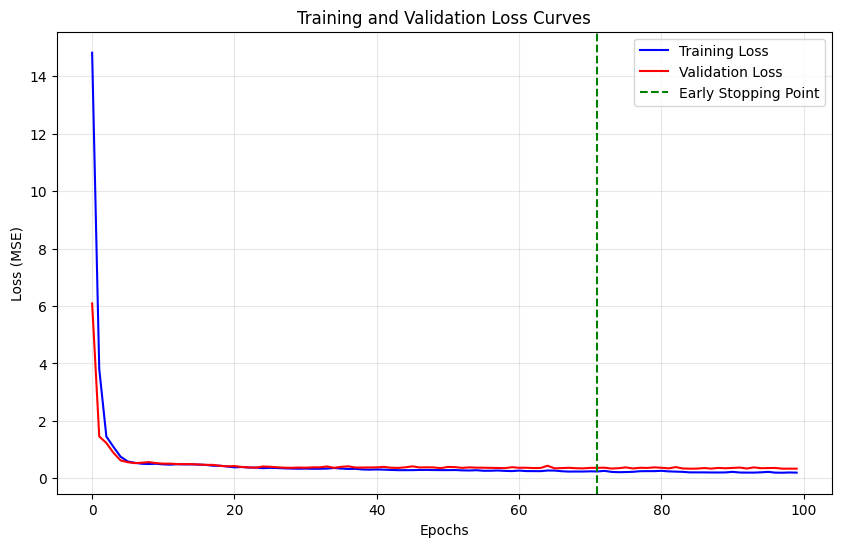

In [24]:
# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
ax.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax.plot(range(len(test_losses)), test_losses, label="Validation Loss", color="red")
ax.axvline(x=71, color="green", linestyle="--", label="Early Stopping Point")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Training and Validation Loss Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [28]:
# Evaluate model performance
from tqdm import tqdm
import numpy as np
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

transformer_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for x_dict, targets in tqdm(test_loader, desc="Evaluating"):
        targets = targets.to(device)

        # Move each modality to device
        for modality in x_dict:
            x_dict[modality] = x_dict[modality].to(device)

        # Forward pass
        outputs, _ = transformer_model(x_dict)  # Unpack tuple here

        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())


# Combine results
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Evaluation metrics
r2 = r2_score(all_targets.flatten(), all_predictions.flatten())
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
mae = mean_absolute_error(all_targets.flatten(), all_predictions.flatten())
evs = explained_variance_score(all_targets.flatten(), all_predictions.flatten())

print("Transformer Model Performance:")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 45.21it/s]

Transformer Model Performance:
R-squared (R²): 0.8875
Root Mean Squared Error (RMSE): 0.5786
Mean Absolute Error (MAE): 0.4215
Explained Variance Score: 0.8879


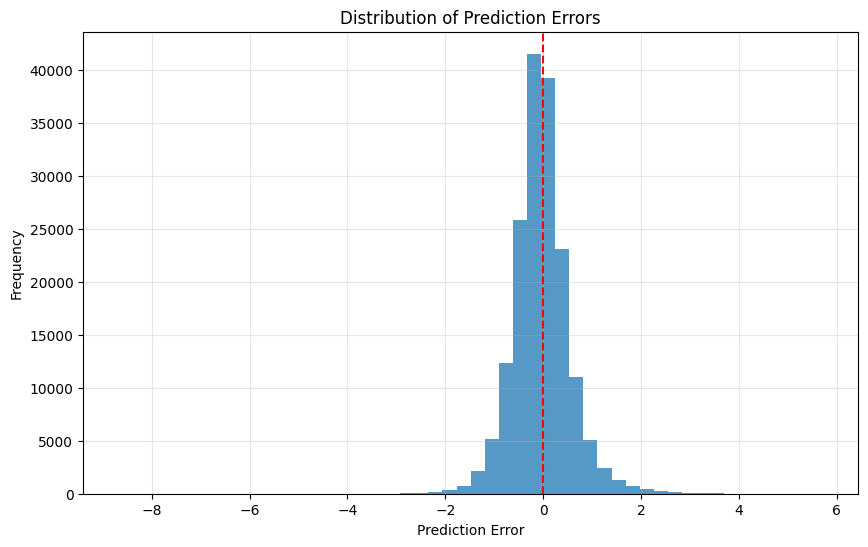

In [26]:
# Plot error distribution
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
errors = (all_predictions - all_targets).flatten()
ax.hist(errors, bins=50, alpha=0.75)
ax.axvline(x=0, color="red", linestyle="--")
ax.set_xlabel("Prediction Error")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Prediction Errors")
ax.grid(True, alpha=0.3)
plt.show()

In [27]:
# global importance of each omics type
# Concatenate and average across samples
attn_tensor = torch.cat(all_weights, dim=0)  # shape: [num_samples, num_modalities]
avg_attention = attn_tensor.mean(dim=0)

print("Average attention per modality:", avg_attention)

Average attention per modality: tensor([0.1340, 0.2342, 0.3143, 0.3175])


## Hyperparameter Tuning <a id="hyperparameter-tuning"></a> 

# Progressive Input Omics Selection <a id="omics-selection"></a> 

# Evaluation Loop <a id="evaluation-loop"></a>

# Results Transformer Models <a id="results-transformer"></a>

- Best omics combination found: transcriptomics only
- Best R² score: 0.8379

(['transcriptomics'],
 {'num_heads': 4,
  'num_layers': 6,
  'hidden_dim': 384,
  'dropout_rate': 0.1,
  'learning_rate': 0.0009052341259832195,
  'weight_decay': 1.1016969061267455e-06,
  'fusion_method': 'gated',
  'activation_function': 'relu'})


## Observations
Although gated fusion method gave the best R^2 score, cross-attention was the most frequently occuring fusion method in top performing models. Perhaps for future work, after cross-validation, dealing with outliers, and especially when the data amount grows, the cross-attention method could be the better performing one.

# Best Predicting Protein Features <a id="results-feature-analysis"></a>

The results that the best predicting proteomic features actually have very low R^2 values, which indicates weak prediction performance and not a lot of variability is explained. The correlation values between the predicted and actual values >0.5 with significant p-values, so the model seems to capture some meaningful relationship between input omics data and protein expression, but not strongly. 


The disconnect between the correlation values and the very low R^2 values suggests that while the model is capturing some general trends in protein expression (hence the correlations), it's not accurately predicting the exact values (hence the poor R^2 values). This could be due to scaling issues in the predictions or systematic biases that the model hasn't learned to correct.


The RMSE values are consistently higher than MAE, suggesting some (larger) errors in the predictions. This because RMSE is more sensitive to outliers (quadratic penalty).